In [28]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    d2_tweedie_score,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

DATA_PATH = "../data"

In [29]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

## Preprocessing

In [30]:
# Separate code into two columns
new_columns = df["CODIGO"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["CODIGO_CLASS"] = new_columns[0]
df["CODIGO_NUM"] = new_columns[1]
df.drop(columns=["CODIGO"], inplace=True)

In [31]:
# FECHAPEDIDO to datetime in day/month/year format
df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)
df.sort_values(by=["FECHAPEDIDO"], inplace=True)
df.reset_index(drop=True, inplace=True)

/var/folders/c6/kf2fcpcj6pq_gwpfbfzzy81m0000gn/T/ipykernel_27441/38037239.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)


In [32]:
# assert all rows in origen follow number-number-number format
def fix_origen_typos(origen_string):
    numbers = re.findall(r"[0-9]+", origen_string)
    return "-".join(numbers)


df["ORIGEN"] = df["ORIGEN"].apply(fix_origen_typos)

In [33]:
# separate ORIGEN in three columns by '-'
origin_separated_columns = df["ORIGEN"].str.split("-", expand=True)
df["PURCHASING_REGION"] = origin_separated_columns[0]
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["ORIGEN"], inplace=True)

In [34]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [35]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["FECHAPEDIDO"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.day / 31)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.dayofyear / 365)
    return df

In [36]:
def add_timeseries_features(df):
    df["ROLLING_MEAN_3M"] = df["CANTIDADCOMPRA"].rolling(90).mean()
    df["WEIGHTED_MEAN_3M"] = (
        df["CANTIDADCOMPRA"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["EWMA_3M"] = df["CANTIDADCOMPRA"].ewm(span=90).mean()
    df["ROLLING_MEAN_1Y"] = df["CANTIDADCOMPRA"].rolling(365).mean()
    df["WEIGHTED_MEAN_1Y"] = (
        df["CANTIDADCOMPRA"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["EWMA_1Y"] = df["CANTIDADCOMPRA"].ewm(span=365).mean()
    # average CANTIDADCOMPRAS over year
    df["AVG_1Y"] = df.groupby(["YEAR"])["CANTIDADCOMPRA"].transform("mean")
    df["AVG_1Y"] = df["AVG_1Y"].fillna(df["AVG_1Y"].mean())
    return df

In [37]:
# get pairings of product and hospital and create a dict "product number": list of hospitals
pairings = df.groupby(["CODIGO_NUM", "PURCHASING_HOSPITAL"]).size().reset_index()
pairings = pairings.groupby(["PURCHASING_HOSPITAL"])["CODIGO_NUM"].apply(list)
pairings = pairings.to_dict()

In [38]:
def generate_train_test_df(full_df):
    # Get train and test sets
    train = full_df[full_df["YEAR"] < 2023]
    X_train = train.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
    y_train = train["CANTIDADCOMPRA"]

    test = full_df[full_df["YEAR"] == 2023]
    X_test = test.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
    y_test = test["CANTIDADCOMPRA"]

    return train, X_train, y_train, test, X_test, y_test

In [39]:
def smape_score(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [40]:
def train_model_eval(X_train, y_train, X_test, y_test):
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    y_test_pred = y_test_pred

    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
    tweedie = d2_tweedie_score(y_test, y_test_pred)
    smape_err = smape_score(y_test, y_test_pred)

    return test_loss, mape_error, smape_err, tweedie

In [41]:
def plot_model_predictions(full_df, product, hospital, plot_train=False):
    columns = ["FECHAPEDIDO", "CANTIDADCOMPRA"]
    partial_df = full_df.loc[
        (full_df["PURCHASING_HOSPITAL"] == hospital)
        & (full_df["CODIGO_NUM"] == product)
    ][columns]
    partial_df = generate_date_features(partial_df)
    partial_df = add_timeseries_features(partial_df)
    train, X_train, y_train, test, X_test, y_test = generate_train_test_df(partial_df)

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    X_train["PREDICTION"] = model.predict(X_train)
    X_train["REAL"] = y_train
    X_train["FECHAPEDIDO"] = train["FECHAPEDIDO"]

    X_test["PREDICTION"] = model.predict(X_test)
    X_test["REAL"] = y_test
    X_test["FECHAPEDIDO"] = test["FECHAPEDIDO"]

    plt.figure(figsize=(30, 10))
    if plot_train:
        sns.lineplot(
            x="FECHAPEDIDO",
            y="PREDICTION",
            data=X_train,
            marker="o",
            label="train preds",
        )
        sns.lineplot(
            x="FECHAPEDIDO", y="REAL", data=X_train, marker="o", label="train real"
        )

    sns.lineplot(
        x="FECHAPEDIDO", y="PREDICTION", data=X_test, marker="o", label="test preds"
    )
    sns.lineplot(x="FECHAPEDIDO", y="REAL", data=X_test, marker="o", label="test real")

    plt.legend()
    plt.show()

In [42]:
%%time

# iterate over each hospital and list of products
columns = ["FECHAPEDIDO", "CANTIDADCOMPRA"]

product_hospital_losses = pd.DataFrame(columns=["PRODUCT", "HOSPITAL", "Tweedie", "MSE", "SMAPE"])
for hospital, product_list in pairings.items():
    for product in product_list:
        partial_df = df.loc[
            (df["PURCHASING_HOSPITAL"] == hospital) & (df["CODIGO_NUM"] == product)
        ][columns]
        partial_df = generate_date_features(partial_df)
        partial_df = add_timeseries_features(partial_df)

        is_2023_in_df = 2023 in partial_df["YEAR"].unique()
        is_only_1_year = partial_df["YEAR"].nunique() == 1
        has_few_samples = partial_df[partial_df["YEAR"] == 2023].shape[0] < 5

        if not is_2023_in_df or is_only_1_year or has_few_samples:
            continue

        train, X_train, y_train, test, X_test, y_test = generate_train_test_df(
            partial_df
        )
        test_loss, mape_error, smape, tweedie = train_model_eval(X_train, y_train, X_test, y_test)

        product_hospital_losses = pd.concat(
            [
                product_hospital_losses,
                pd.DataFrame(
                    [[product, hospital, tweedie, test_loss, smape]],
                    columns=["PRODUCT", "HOSPITAL", "Tweedie", "MSE", "SMAPE"],
                ),
            ]
        )

CPU times: user 5.43 s, sys: 5.43 s, total: 10.9 s
Wall time: 8.48 s


In [56]:
product_hospital_losses.sort_values(by=["MSE"], ascending=False).head(20)

,PRODUCT,HOSPITAL,Tweedie,MSE,SMAPE
0,66071,7,-0.666667,2162.997939,72.380964
0,66071,13,-0.972549,1381.658753,69.268008
0,85758,10,-9.330963,424.117832,41.967628
0,64911,7,-0.250000,402.492263,24.000019
0,64764,0,-1.166614,376.817257,32.754517
0,64764,18,-0.365948,366.439863,10.167945
0,64751,0,-0.111203,348.622702,12.668822
0,64765,0,-1.365553,344.519910,34.058498
0,64764,10,-2.465778,329.302830,38.659885
0,64765,18,-0.266566,252.093634,10.737253


In [48]:
product_hospital_losses.groupby(["PRODUCT"])["MSE"].mean().sort_values(
    ascending=False
).head(20)

PRODUCT
66071    920.009225
64764    357.519983
64765    298.306772
64751    256.054958
64911    242.701280
73753    203.710348
85758    171.066012
65056    130.131834
64488    103.035913
64663     99.655092
64940     97.370373
64932     95.249517
64983     70.391758
85769     68.321601
65894     60.040401
65509     59.770322
65486     49.770596
70130     47.364918
99807     28.060142
41691     27.142854
Name: MSE, dtype: float64

In [45]:
product_hospital_losses[product_hospital_losses["Tweedie"] != -np.inf]["Tweedie"].mean()

-6.788815851015224

In [55]:
product_hospital_losses["MSE"].mean()

98.53393324552067

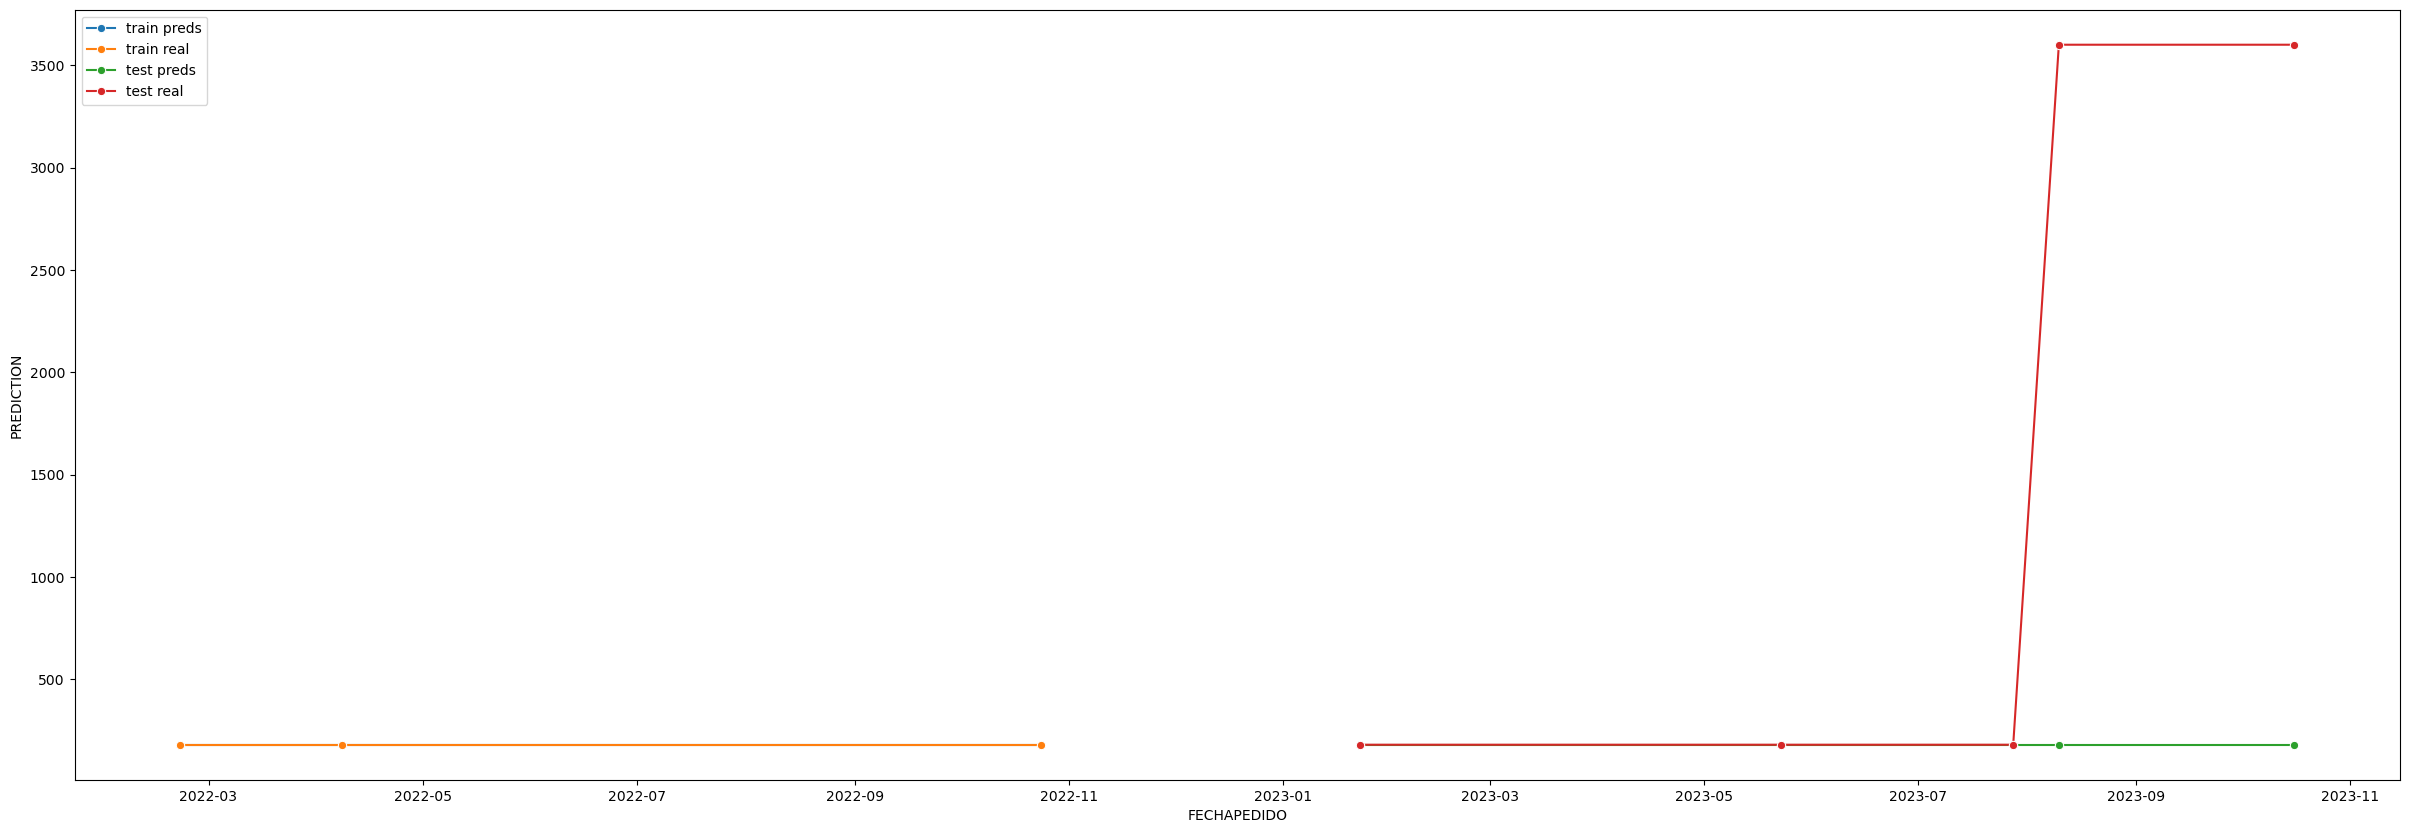

In [58]:
plot_model_predictions(full_df=df, product="66071", hospital="7", plot_train=True)